## Import Modules

In [1]:
# Import all the required modules
import math
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

if 'google.colab' in sys.modules:
    # Download the repo from GitHub
    print("Downloading repository on Colab...")
    !git clone https://github.com/Shilpaj1994/ERA.git

    # Import files from the downloaded repository
    sys.path.insert(0,'./ERA/Session8/')

Cloning into 'ERA'...
remote: Enumerating objects: 222, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (168/168), done.
remote: Total 222 (delta 84), reused 190 (delta 52), pack-reused 0
Receiving objects: 100% (222/222), 27.81 MiB | 24.14 MiB/s, done.
Resolving deltas: 100% (84/84), done.


# Dataset Analysis

## Extract and Load the Data

In [2]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
test = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 61029828.75it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Data Statistics

[Train]
 - Total Train Images: 50000
 - Tensor Shape: (3, 32, 32)
 - min: (0.0, 0.0, 0.0)
 - max: (1.0, 1.0, 1.0)
 - mean: (0.49139968, 0.48215827, 0.44653124)
 - std: (0.24703233, 0.24348505, 0.26158768)
 - var: (0.061024975, 0.05928497, 0.06842812)
[Test]
 - Total Test Images: 10000
 - Tensor Shape: (3, 32, 32)
 - min: (0.0, 0.0, 0.0)
 - max: (1.0, 1.0, 1.0)
 - mean: (0.49421427, 0.48513183, 0.45040932)
 - std: (0.24665256, 0.24289224, 0.26159248)
 - var: (0.06083748, 0.058996636, 0.06843062)


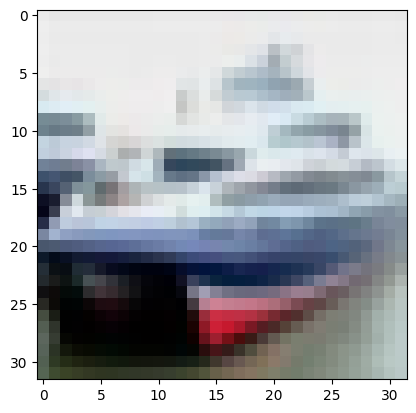

In [3]:
from utils import get_cifar_statistics

get_cifar_statistics(train)
get_cifar_statistics(test, data_set_type="Test")

## Parameters

In [4]:
BATCH_SIZE = 512
EPOCHS = 20
DISPLAY_SAMPLES = 20
LEARNING_RATE = 0.02
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0001
MAX_LR = 0.1
STEPS_PER_EPOCH = math.ceil(50_000/BATCH_SIZE)

## Visualize Training Data

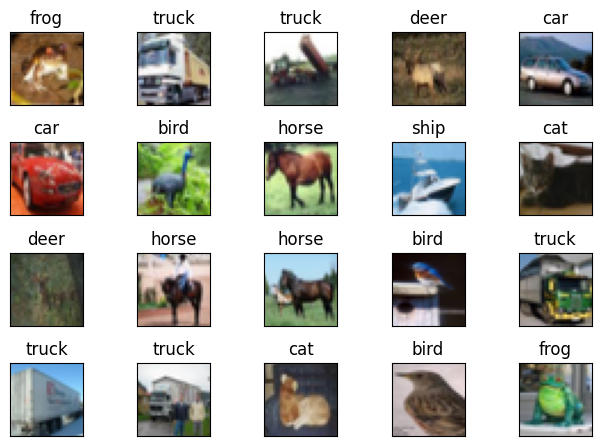

In [5]:
from visualize import display_data_samples

display_data_samples(train, DISPLAY_SAMPLES, classes, dataset='CIFAR')

## Transformations

In [6]:
# Train Phase transformations
train_set_transforms = {
    'randomcrop': transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    'horizontalflip': transforms.RandomHorizontalFlip(),
    'rotation': transforms.RandomRotation(15),
    'standardize': transforms.ToTensor(),
    'normalize': transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    # 'affine': transforms.RandomAffine(degrees=(-7, 7), translate=(0.1, 0.1), scale=(0.09, 1.0)),
    # 'randomcrop': transforms.RandomResizedCrop((32, 32), (0.85, 1.0)),
    # 'cutout': transforms.RandomErasing()
}

# Test Phase transformations
test_set_transforms = {
    'standardize': transforms.ToTensor(),
    'normalize': transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
}

train_transforms = transforms.Compose(train_set_transforms.values())
test_transforms = transforms.Compose(test_set_transforms.values())

In [7]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


## Visualize Augmentations

In [8]:
# from visualize import visualize_augmentation


# # del train_set_transforms['standardize']
# train_set_transforms['PIL'] = transforms.ToPILImage()
# print(train_set_transforms.keys())
# visualize_augmentation(train, train_set_transforms)

## Dataloader Arguments & Test/Train Dataloaders

In [9]:
SEED = 8

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## Model and its Parameters

In [10]:
from model import Session8
from utils import get_summary

cpu_model = Session8(normalization='batch')
get_summary(cpu_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 32, 32]             540
              ReLU-2           [-1, 20, 32, 32]               0
       BatchNorm2d-3           [-1, 20, 32, 32]              40
           Dropout-4           [-1, 20, 32, 32]               0
            Conv2d-5           [-1, 20, 32, 32]           3,600
              ReLU-6           [-1, 20, 32, 32]               0
       BatchNorm2d-7           [-1, 20, 32, 32]              40
           Dropout-8           [-1, 20, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             320
             ReLU-10           [-1, 16, 32, 32]               0
      BatchNorm2d-11           [-1, 16, 32, 32]              32
          Dropout-12           [-1, 16, 32, 32]               0
        MaxPool2d-13           [-1, 16, 16, 16]               0
           Conv2d-14           [-1, 26,

## Model Training and Testing

In [11]:
from training_utils import train, test

In [12]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []
test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}


# Put the model on selected device
model = cpu_model.to(device)

# Optimization algorithm to update the weights
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Scheduler to change the learning rate after specific number of epochs
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=MAX_LR, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS)

# New Line
criterion = F.nll_loss


# For each epoch
for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}')

    # Train the model on training dataset and append the training loss and accuracy
    correct, processed, train_loss = train(model, device, train_loader, optimizer, criterion, scheduler)
    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader))

    # Test the model's performance on test dataset and append the training loss and accuracy
    correct, test_loss = test(model, device, test_loader, criterion)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

Epoch 1


Train: Loss=1.6098 Batch_id=97 Accuracy=30.56: 100%|██████████| 98/98 [00:33<00:00,  2.95it/s]


Test set: Average loss: 1.7083, Accuracy: 3647/10000 (36.47%)

Epoch 2


Train: Loss=1.3796 Batch_id=97 Accuracy=45.82: 100%|██████████| 98/98 [00:32<00:00,  3.03it/s]


Test set: Average loss: 1.5171, Accuracy: 4550/10000 (45.50%)

Epoch 3


Train: Loss=1.2122 Batch_id=97 Accuracy=52.80: 100%|██████████| 98/98 [00:33<00:00,  2.90it/s]


Test set: Average loss: 1.4264, Accuracy: 4803/10000 (48.03%)

Epoch 4


Train: Loss=1.1761 Batch_id=97 Accuracy=56.97: 100%|██████████| 98/98 [00:33<00:00,  2.97it/s]


Test set: Average loss: 1.1915, Accuracy: 5700/10000 (57.00%)

Epoch 5


Train: Loss=1.0653 Batch_id=97 Accuracy=59.67: 100%|██████████| 98/98 [00:32<00:00,  2.99it/s]


Test set: Average loss: 1.0923, Accuracy: 6116/10000 (61.16%)

Epoch 6


Train: Loss=1.0652 Batch_id=97 Accuracy=61.86: 100%|██████████| 98/98 [00:32<00:00,  3.02it/s]


Test set: Average loss: 1.0682, Accuracy: 6185/10000 (61.85%)

Epoch 7


Train: Loss=1.0599 Batch_id=97 Accuracy=63.33: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]


Test set: Average loss: 1.0000, Accuracy: 6493/10000 (64.93%)

Epoch 8


Train: Loss=0.9505 Batch_id=97 Accuracy=64.64: 100%|██████████| 98/98 [00:33<00:00,  2.93it/s]


Test set: Average loss: 1.0343, Accuracy: 6262/10000 (62.62%)

Epoch 9


Train: Loss=0.9494 Batch_id=97 Accuracy=65.63: 100%|██████████| 98/98 [00:33<00:00,  2.91it/s]


Test set: Average loss: 0.9633, Accuracy: 6614/10000 (66.14%)

Epoch 10


Train: Loss=0.9102 Batch_id=97 Accuracy=66.54: 100%|██████████| 98/98 [00:35<00:00,  2.73it/s]


Test set: Average loss: 0.9715, Accuracy: 6629/10000 (66.29%)

Epoch 11


Train: Loss=0.9291 Batch_id=97 Accuracy=67.32: 100%|██████████| 98/98 [00:33<00:00,  2.97it/s]


Test set: Average loss: 0.8995, Accuracy: 6812/10000 (68.12%)

Epoch 12


Train: Loss=0.9405 Batch_id=97 Accuracy=67.72: 100%|██████████| 98/98 [00:33<00:00,  2.96it/s]


Test set: Average loss: 0.8283, Accuracy: 7059/10000 (70.59%)

Epoch 13


Train: Loss=0.7983 Batch_id=97 Accuracy=68.70: 100%|██████████| 98/98 [00:32<00:00,  2.98it/s]


Test set: Average loss: 0.8521, Accuracy: 7011/10000 (70.11%)

Epoch 14


Train: Loss=0.8079 Batch_id=97 Accuracy=69.26: 100%|██████████| 98/98 [00:34<00:00,  2.83it/s]


Test set: Average loss: 0.8701, Accuracy: 6906/10000 (69.06%)

Epoch 15


Train: Loss=0.8447 Batch_id=97 Accuracy=70.07: 100%|██████████| 98/98 [00:34<00:00,  2.86it/s]


Test set: Average loss: 0.8283, Accuracy: 7088/10000 (70.88%)

Epoch 16


Train: Loss=0.7910 Batch_id=97 Accuracy=70.72: 100%|██████████| 98/98 [00:34<00:00,  2.88it/s]


Test set: Average loss: 0.8012, Accuracy: 7140/10000 (71.40%)

Epoch 17


Train: Loss=0.7831 Batch_id=97 Accuracy=71.64: 100%|██████████| 98/98 [00:34<00:00,  2.87it/s]


Test set: Average loss: 0.7805, Accuracy: 7209/10000 (72.09%)

Epoch 18


Train: Loss=0.7658 Batch_id=97 Accuracy=71.97: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]


Test set: Average loss: 0.7652, Accuracy: 7278/10000 (72.78%)

Epoch 19


Train: Loss=0.7910 Batch_id=97 Accuracy=72.59: 100%|██████████| 98/98 [00:33<00:00,  2.97it/s]


Test set: Average loss: 0.7597, Accuracy: 7308/10000 (73.08%)

Epoch 20


Train: Loss=0.7358 Batch_id=97 Accuracy=72.91: 100%|██████████| 98/98 [00:33<00:00,  2.95it/s]


Test set: Average loss: 0.7555, Accuracy: 7327/10000 (73.27%)



## Visualize Train and Test - Loss and Accuracies

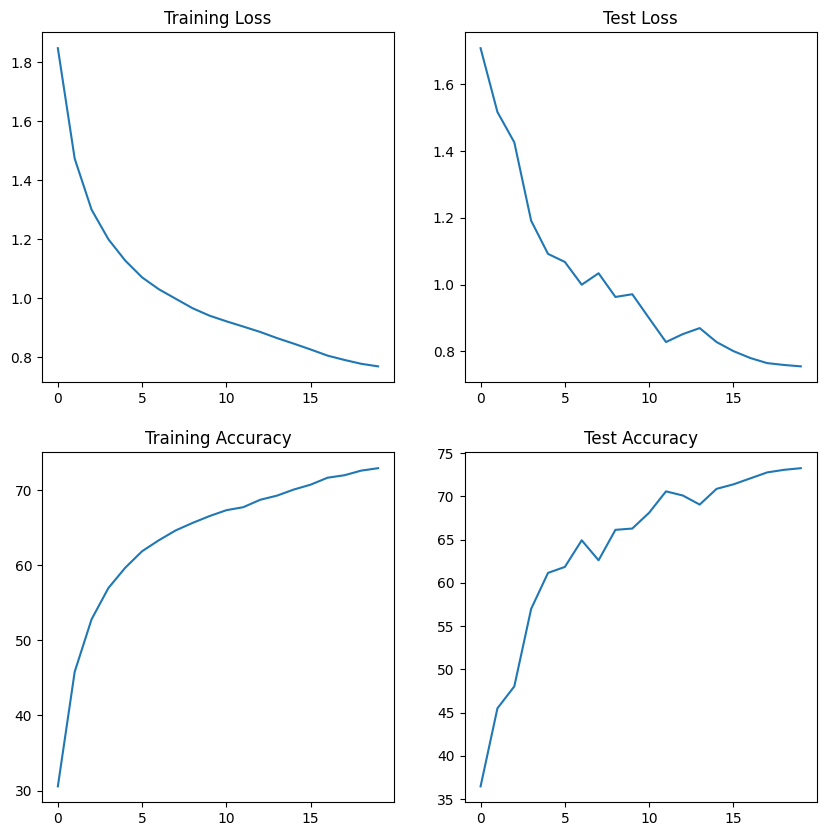

In [13]:
# Print loss and accuracy
from visualize import display_loss_and_accuracies

display_loss_and_accuracies(train_losses, train_acc, test_losses, test_acc)

## Visualize Misclassified Images

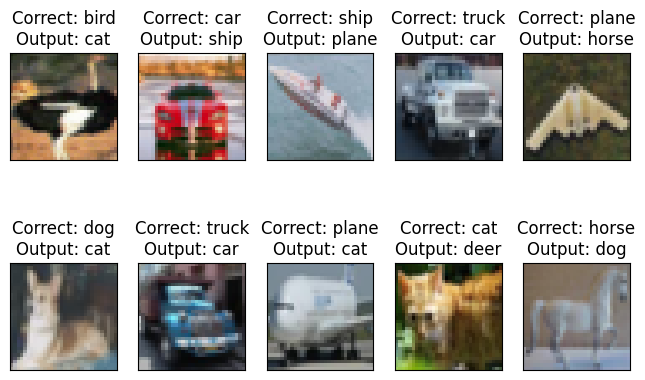

In [14]:
from utils import get_misclassified_data
from visualize import plot_data

# Denormalize the data using test mean and std deviation
inv_normalize = transforms.Normalize(
    mean=[-0.4942/0.2466, -0.4851/0.2428, -0.4504/0.2615],
    std=[1/0.2466, 1/0.2428, 1/0.2615]
)

# Get the misclassified data from test dataset
misclassified_data = get_misclassified_data(model, device, test_loader)

# Plot the misclassified data
plot_data(misclassified_data, classes, inv_normalize, number_of_samples=10)